In [ ]:
!pip install torch_snippets
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 57 kB 3.5 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 208 kB 12.4 MB/s 
     |████████████████████████████████| 51 kB 4.8 MB/s 


2021-08-03 17:07:33.891 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-03 17:07:34.600 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
#Download the dataset and define the training and validation datasets and data loaders

from torchvision import datasets
import torch
data_folder = '~/cifar10/cifar/'
datasets.CIFAR10(data_folder,download=True)



Extracting /root/cifar10/cifar/cifar-10-python.tar.gz to /root/cifar10/cifar/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /root/cifar10/cifar/
    Split: Train

In [ ]:
class Colorize(torchvision.datasets.CIFAR10):
        def __init__(self, root, train):


            super().__init__(root, train)
        def __getitem__(self, ix):


            im, _ = super().__getitem__(ix)
            bw = im.convert('L').convert('RGB') 
            bw, im = np.array(bw)/255., np.array(im)/255.
            bw, im = [torch.tensor(i).permute(2,0,1)\
                  .to(device).float() for i in [bw,im]]
            return bw,im


trn_ds = Colorize('~/cifar10/cifar/', train=True)
val_ds = Colorize('~/cifar10/cifar/', train=False)
trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)

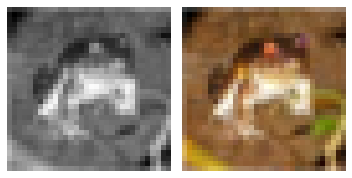

In [ ]:
# a sample of input and output images is as follows

a , b = trn_ds[0]
subplots([a,b],nc=2)

In [ ]:
# Define the network architecture

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x

class DownConv(nn.Module):
    def __init__(self,ni,no,maxpool=True):
        super().__init__()
        self.model = nn.Sequential(

            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),

        )
    def forward(self,x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self,ni,no,maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni,no,\
                                                2,stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def forward(self,x,y):
        x = self.convtranspose(x)
        x = torch.cat([x,y],axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv(3,64,maxpool=False)
        self.d2 = DownConv(64,128)
        self.d3 = DownConv(128,256)
        self.d4 = DownConv(256,512)
        self.d5 = DownConv(512,1024)
        self.u5 = UpConv(1024,512)
        self.u4 = UpConv(512,256)
        self.u3 = UpConv(256,128)
        self.u2 = UpConv(128,64)
        self.u1 = nn.Conv2d(64,3,kernel_size=1, stride=1)

    def forward(self,x):
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        X4 = self.u5(x4,x3)
        X3 = self.u4(X4,x2)
        X2 = self.u3(X3,x1)
        X1 = self.u2(X2,x0)
        X0 = self.u1(X1)
        return X0
        

In [ ]:
# defin the model,optimizer and loss function

def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    loss_fn = nn.MSELoss()
    return model,optimizer,loss_fn

In [ ]:
# define the function to train and validate on the batch of data

def train_batch(model,data,optimizer,criterion):
    model.train()
    x,y= data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y,y)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model,data,criterion):
    model.eval()
    x,y = data
    _y = model(x)
    loss = criterion(_y,y)
    return loss.item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 0.255	trn_loss: 0.008	(59.83s - 23392.60s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


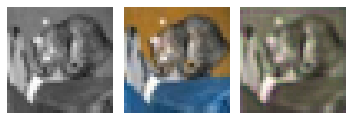

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


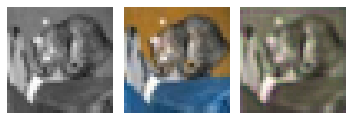

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


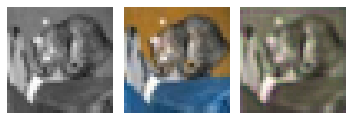

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


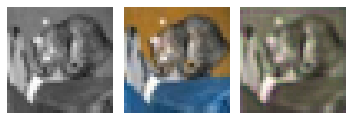

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


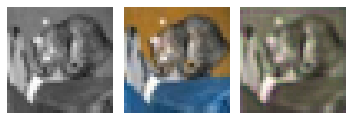

EPOCH: 0.510	trn_loss: 0.006	(121.84s - 23759.50s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


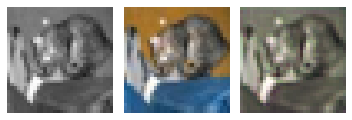

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


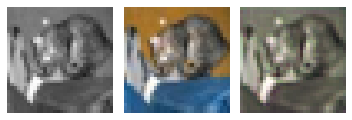

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


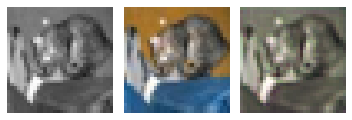

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


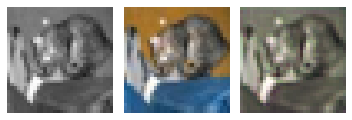

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


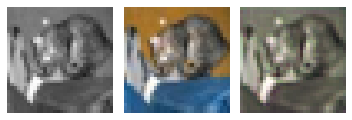

EPOCH: 0.765	trn_loss: 0.008	(183.98s - 23855.60s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


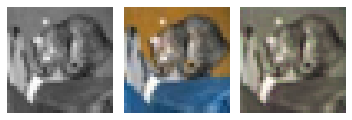

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


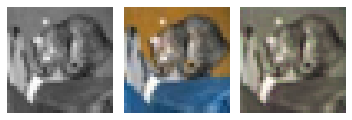

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


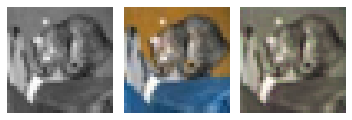

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


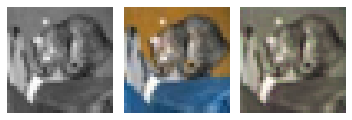

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


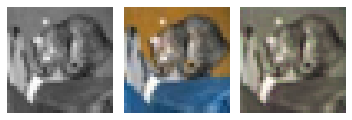

EPOCH: 1.255	trn_loss: 0.006	(300.18s - 23616.96s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


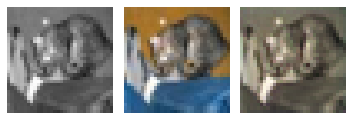

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


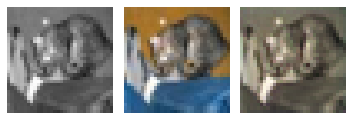

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


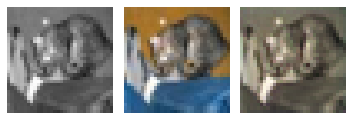

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


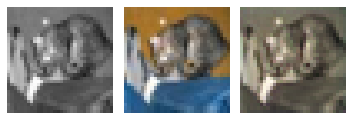

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


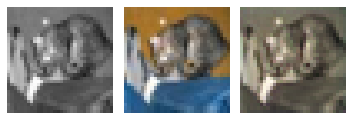

EPOCH: 1.510	trn_loss: 0.007	(362.15s - 23617.92s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


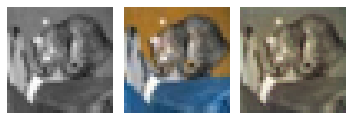

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


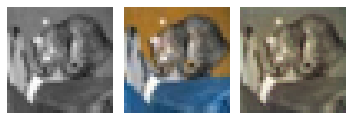

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


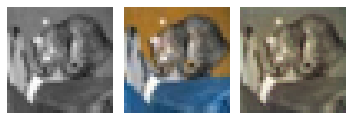

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


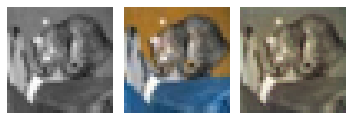

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


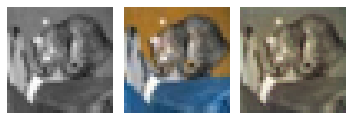

EPOCH: 1.765	trn_loss: 0.006	(424.24s - 23607.78s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


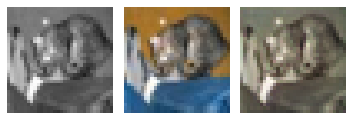

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


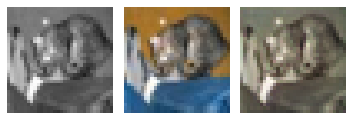

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


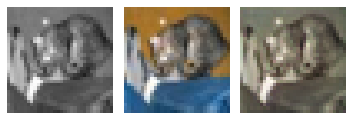

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


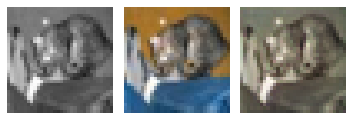

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


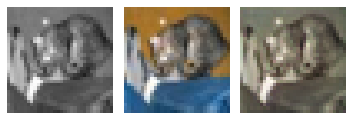

EPOCH: 2.255	trn_loss: 0.005	(540.39s - 23422.45s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


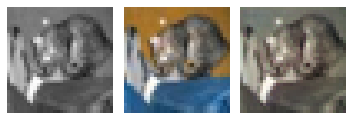

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


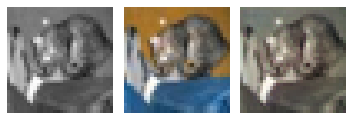

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


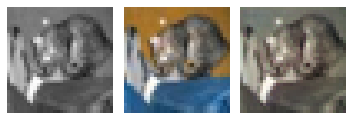

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


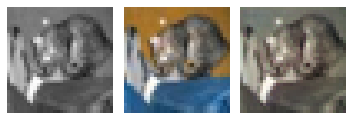

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


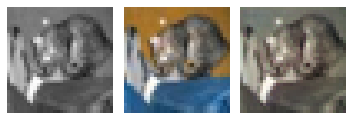

EPOCH: 2.510	trn_loss: 0.005	(602.44s - 23397.25s remaining)

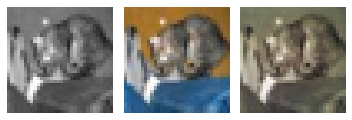

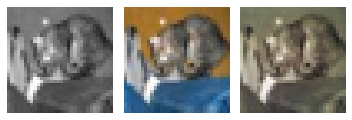

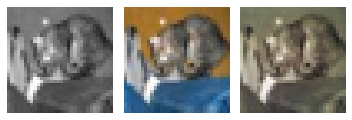

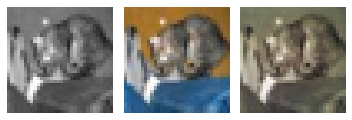

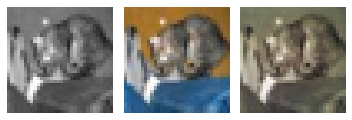

EPOCH: 2.765	trn_loss: 0.006	(664.53s - 23366.57s remaining)

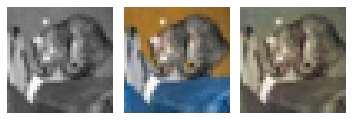

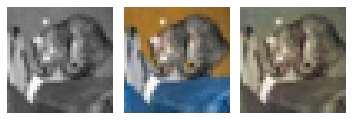

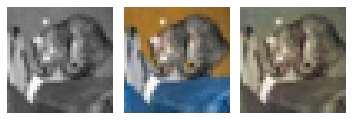

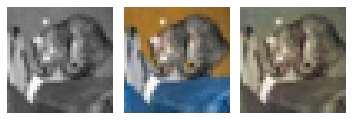

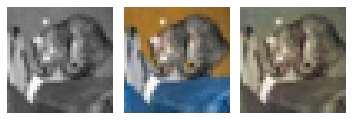

EPOCH: 3.255	trn_loss: 0.005	(780.52s - 23197.79s remaining)

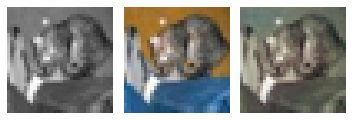

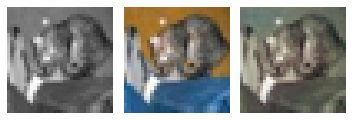

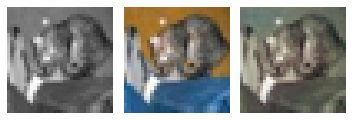

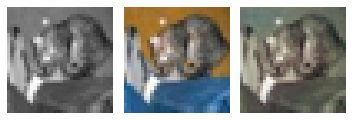

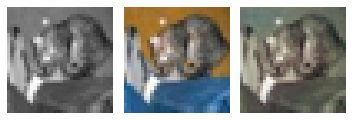

EPOCH: 3.510	trn_loss: 0.006	(842.40s - 23156.11s remaining)

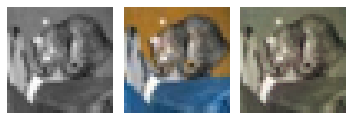

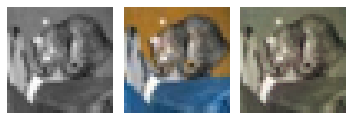

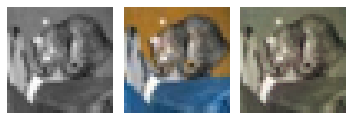

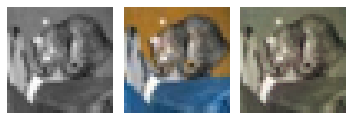

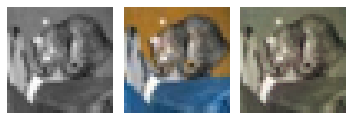

EPOCH: 3.765	trn_loss: 0.006	(904.45s - 23116.12s remaining)

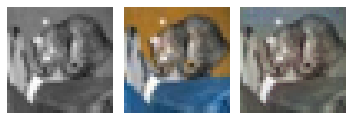

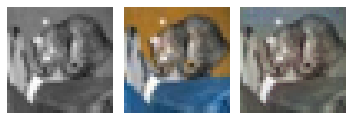

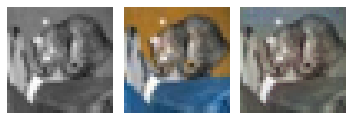

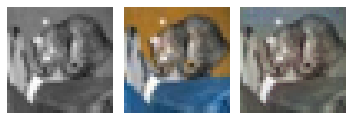

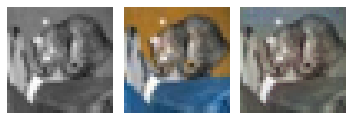

EPOCH: 4.255	trn_loss: 0.005	(1020.41s - 22960.55s remaining)

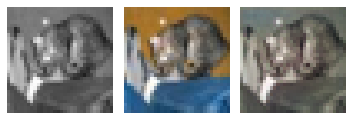

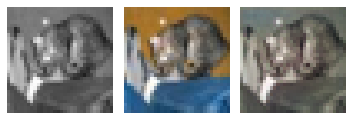

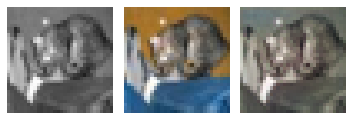

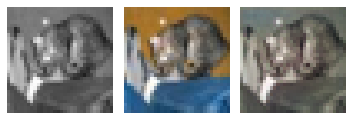

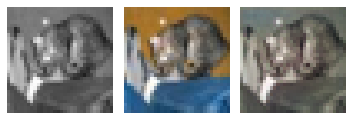

EPOCH: 4.510	trn_loss: 0.005	(1082.29s - 22914.25s remaining)

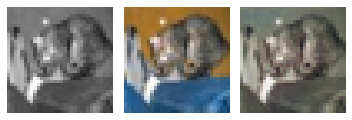

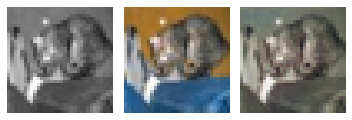

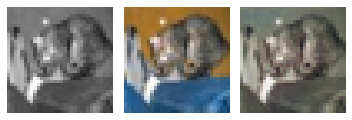

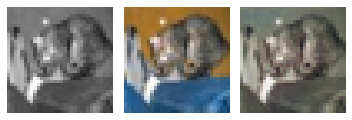

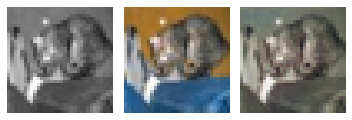

EPOCH: 4.765	trn_loss: 0.005	(1144.27s - 22868.20s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


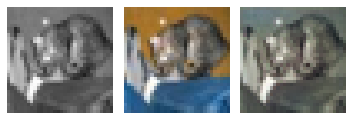

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


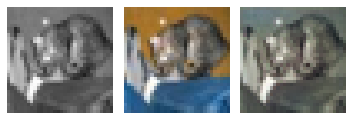

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


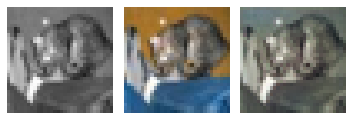

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


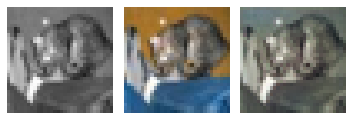

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


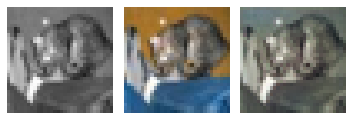

EPOCH: 5.255	trn_loss: 0.005	(1260.25s - 22721.12s remaining)

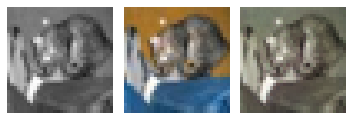

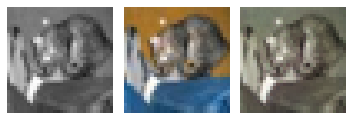

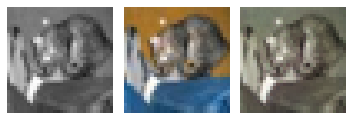

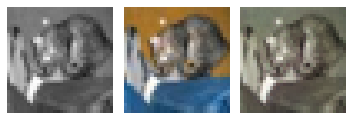

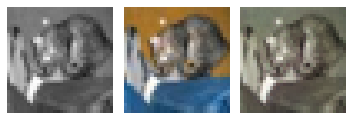

EPOCH: 5.510	trn_loss: 0.006	(1322.15s - 22672.51s remaining)

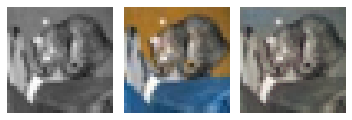

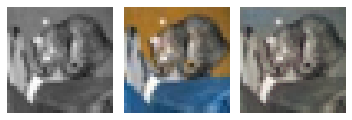

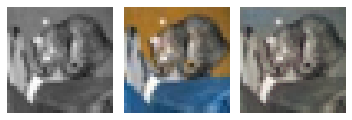

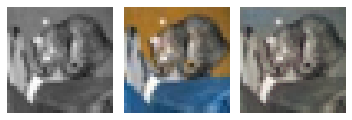

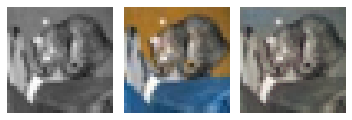

EPOCH: 5.765	trn_loss: 0.006	(1384.19s - 22624.69s remaining)

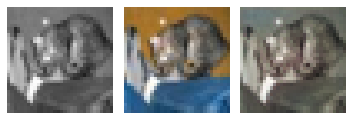

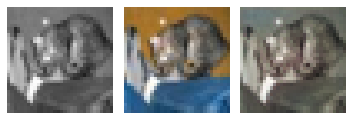

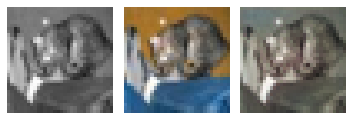

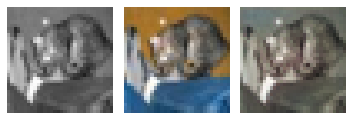

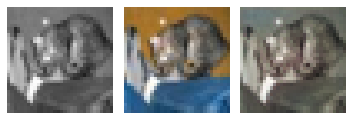

EPOCH: 6.255	trn_loss: 0.005	(1500.09s - 22481.78s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


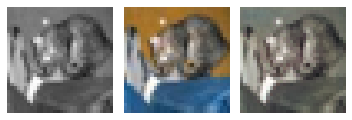

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


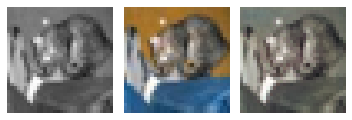

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


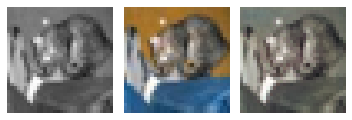

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


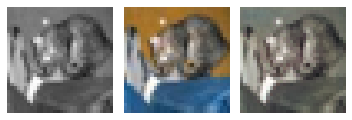

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


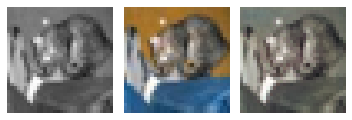

EPOCH: 6.510	trn_loss: 0.006	(1561.99s - 22430.95s remaining)

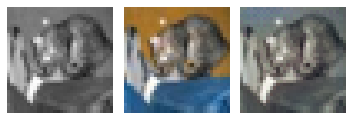

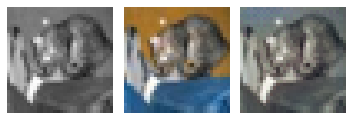

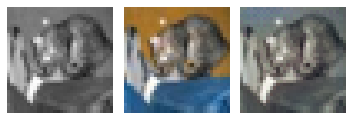

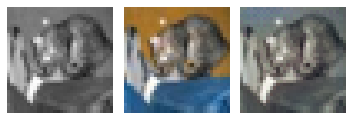

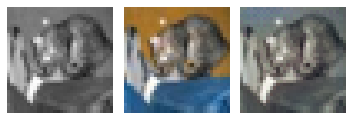

EPOCH: 6.765	trn_loss: 0.005	(1623.93s - 22379.86s remaining)

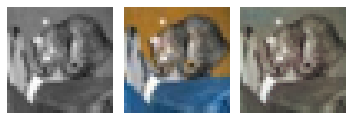

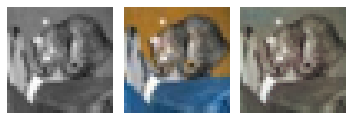

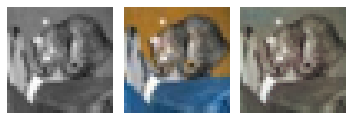

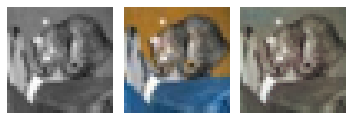

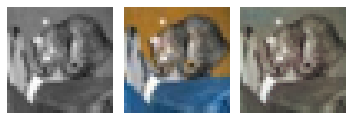

EPOCH: 7.255	trn_loss: 0.005	(1739.53s - 22237.11s remaining)

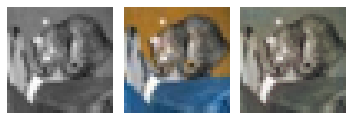

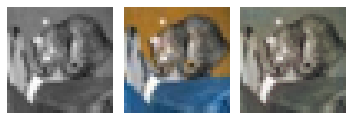

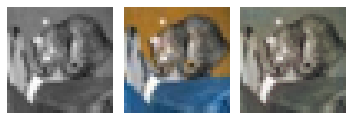

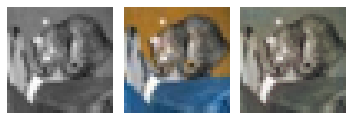

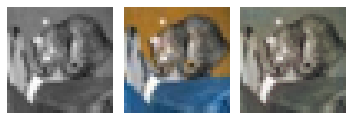

EPOCH: 7.510	trn_loss: 0.007	(1801.48s - 22185.61s remaining)

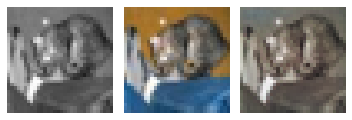

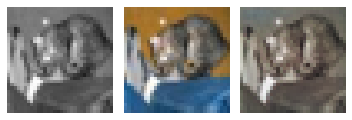

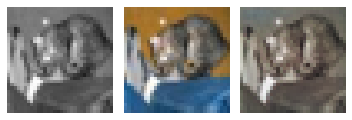

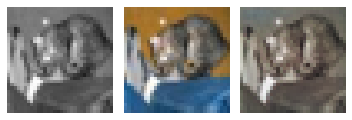

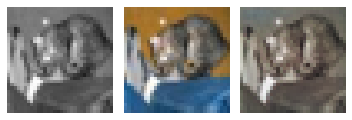

EPOCH: 7.765	trn_loss: 0.004	(1863.46s - 22133.82s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


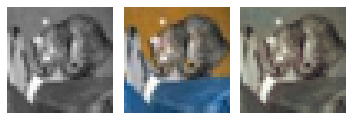

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


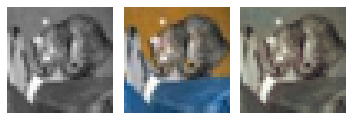

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


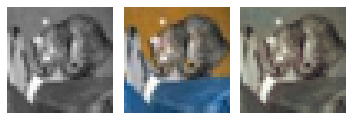

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


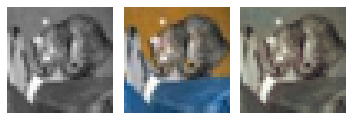

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


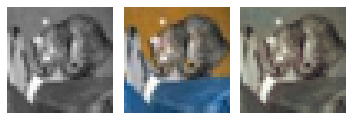

EPOCH: 8.255	trn_loss: 0.006	(1979.34s - 21997.87s remaining)

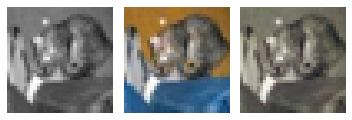

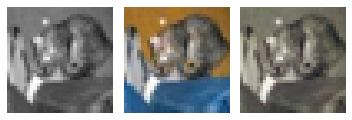

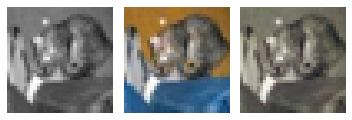

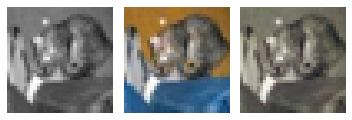

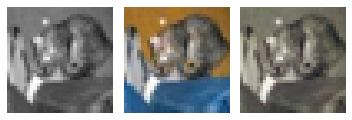

EPOCH: 8.510	trn_loss: 0.006	(2041.33s - 21945.51s remaining)

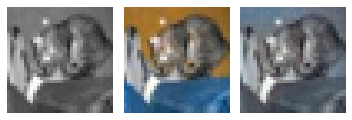

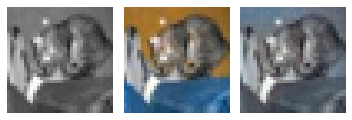

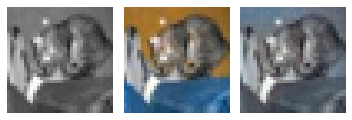

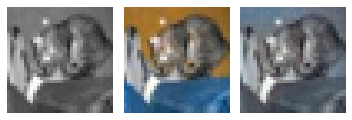

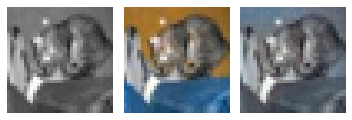

EPOCH: 8.765	trn_loss: 0.005	(2103.54s - 21894.95s remaining)

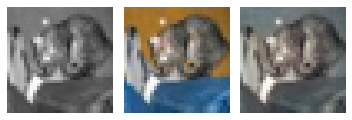

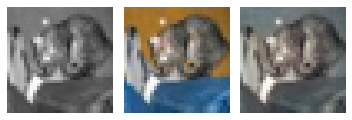

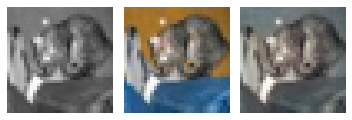

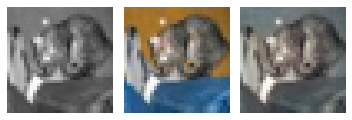

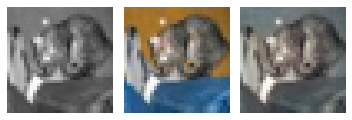

EPOCH: 9.255	trn_loss: 0.005	(2219.71s - 21763.91s remaining)

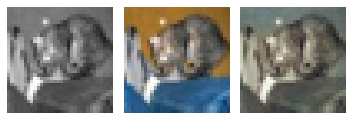

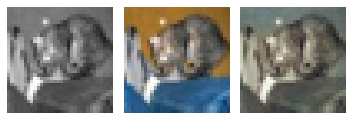

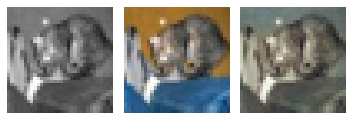

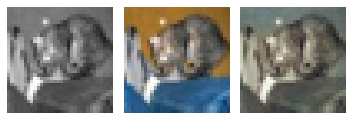

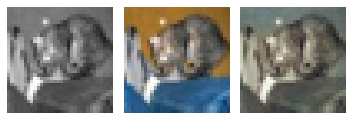

EPOCH: 9.510	trn_loss: 0.005	(2281.68s - 21710.27s remaining)

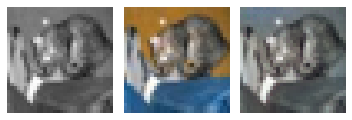

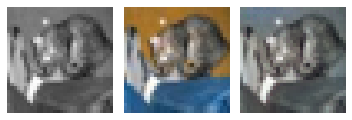

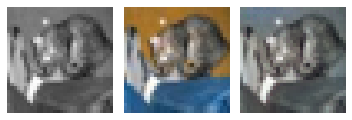

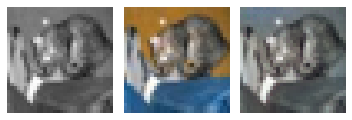

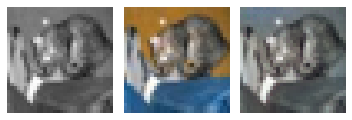

EPOCH: 9.765	trn_loss: 0.006	(2343.72s - 21656.74s remaining)

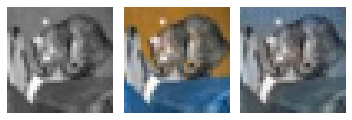

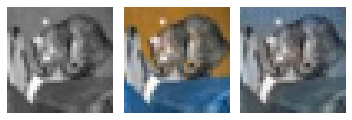

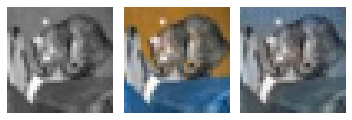

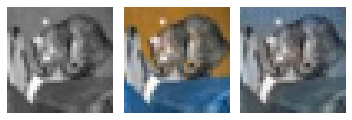

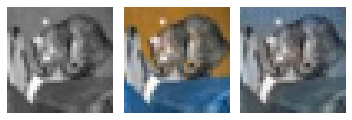

EPOCH: 10.255	trn_loss: 0.005	(2459.81s - 21526.39s remaining)

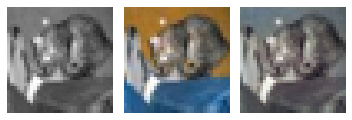

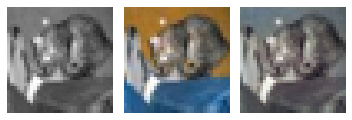

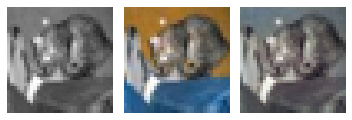

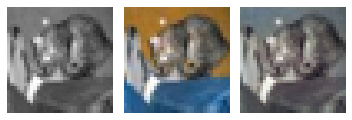

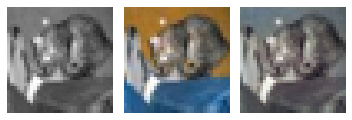

EPOCH: 10.510	trn_loss: 0.005	(2521.84s - 21472.40s remaining)

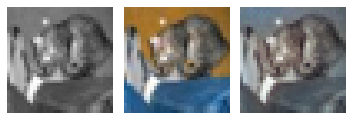

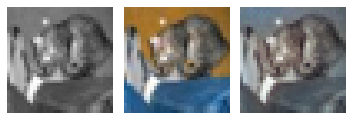

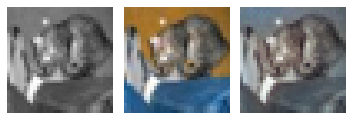

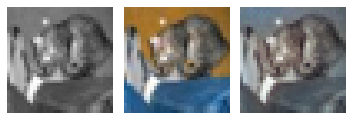

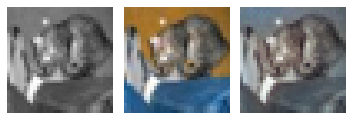

EPOCH: 10.765	trn_loss: 0.005	(2583.94s - 21418.54s remaining)

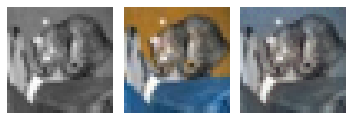

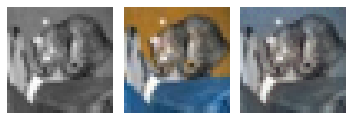

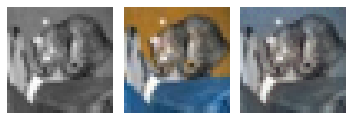

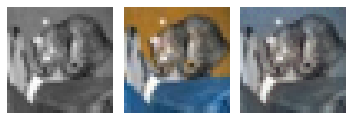

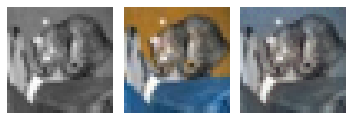

EPOCH: 11.255	trn_loss: 0.005	(2699.51s - 21285.25s remaining)

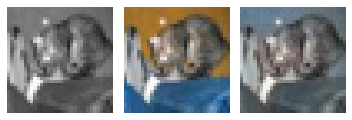

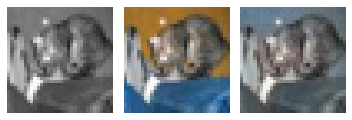

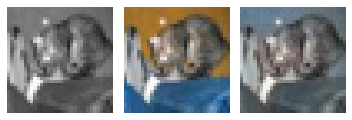

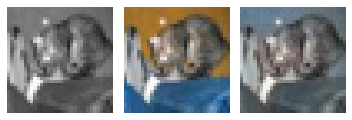

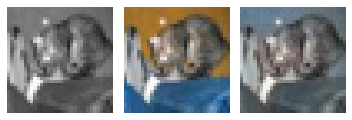

EPOCH: 11.510	trn_loss: 0.005	(2760.99s - 21226.36s remaining)

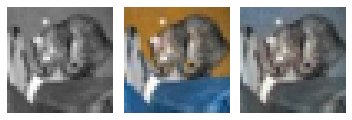

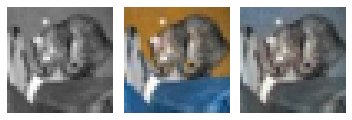

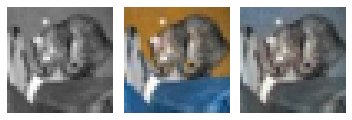

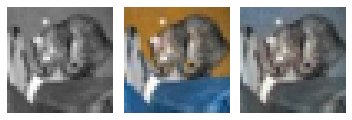

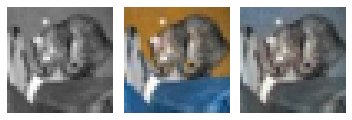

EPOCH: 11.765	trn_loss: 0.006	(2822.19s - 21165.19s remaining)

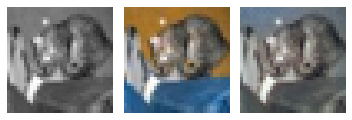

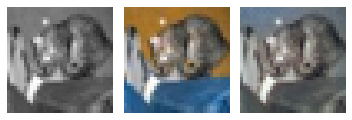

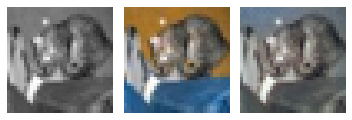

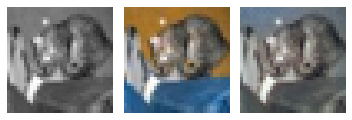

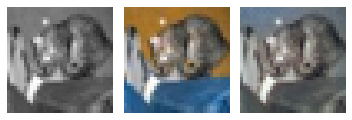

EPOCH: 12.255	trn_loss: 0.005	(2936.61s - 21025.75s remaining)

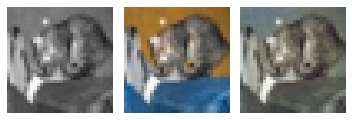

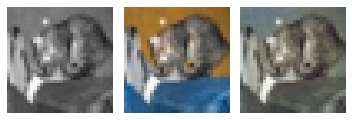

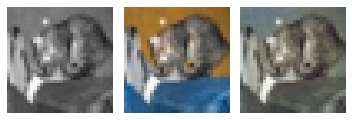

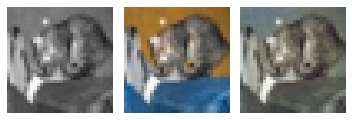

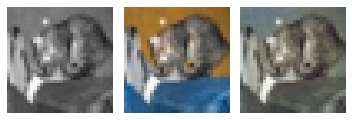

EPOCH: 12.510	trn_loss: 0.005	(2997.62s - 20963.78s remaining)

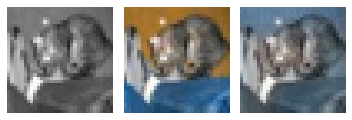

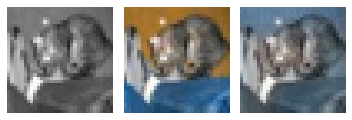

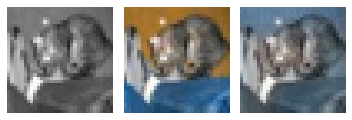

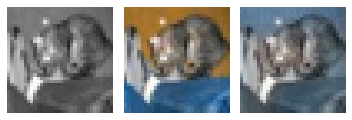

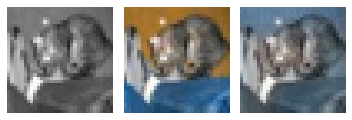

EPOCH: 12.765	trn_loss: 0.004	(3059.05s - 20904.76s remaining)

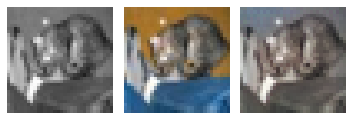

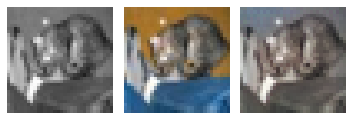

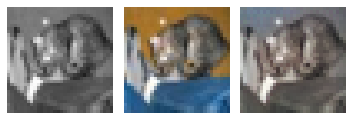

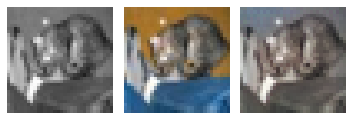

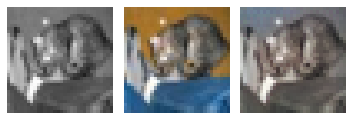

EPOCH: 13.255	trn_loss: 0.005	(3174.39s - 20774.06s remaining)

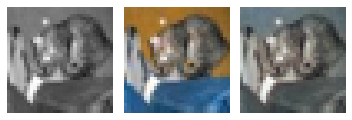

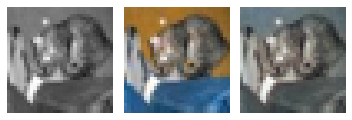

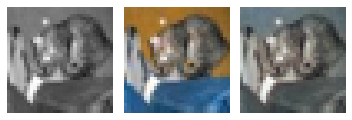

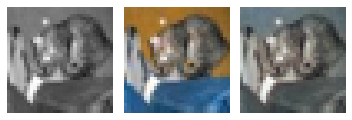

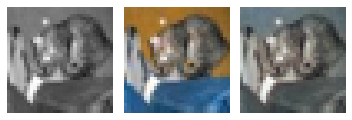

EPOCH: 13.510	trn_loss: 0.004	(3235.97s - 20716.05s remaining)

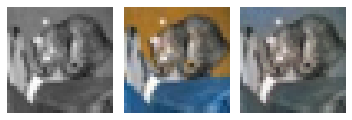

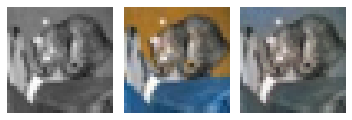

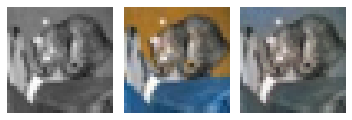

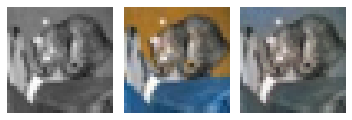

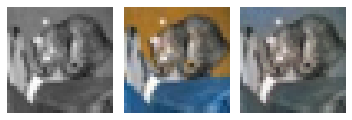

EPOCH: 13.765	trn_loss: 0.005	(3297.69s - 20658.81s remaining)

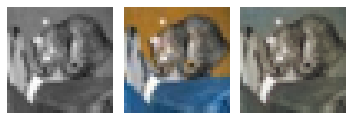

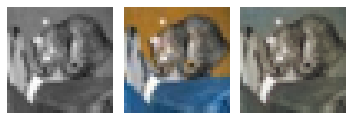

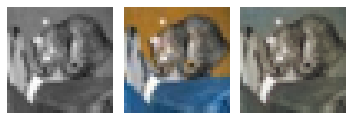

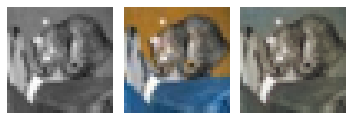

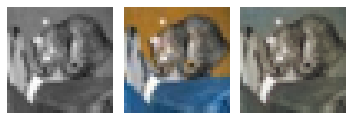

EPOCH: 14.255	trn_loss: 0.005	(3413.19s - 20530.42s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


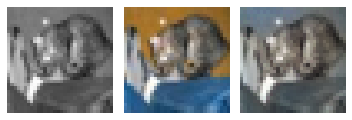

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


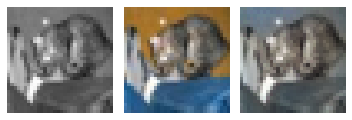

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


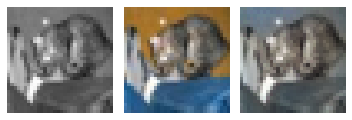

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


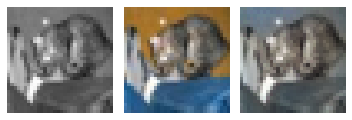

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


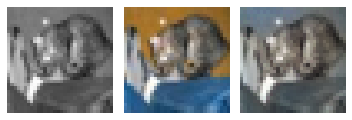

EPOCH: 14.510	trn_loss: 0.004	(3474.88s - 20472.98s remaining)

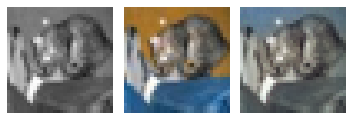

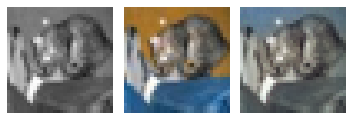

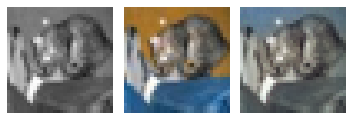

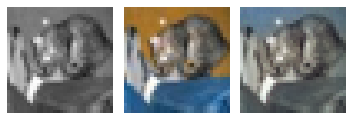

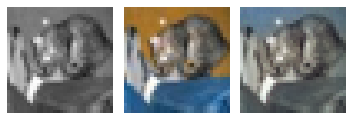

EPOCH: 14.765	trn_loss: 0.005	(3536.56s - 20415.24s remaining)

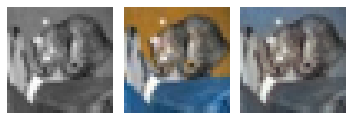

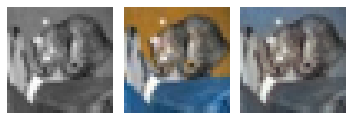

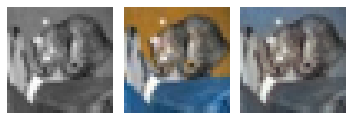

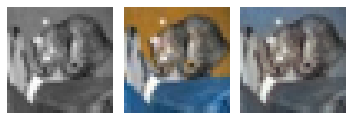

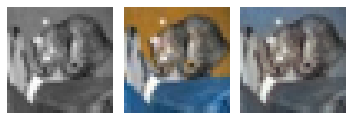

EPOCH: 15.255	trn_loss: 0.005	(3650.96s - 20281.77s remaining)

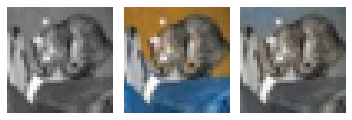

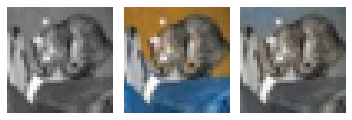

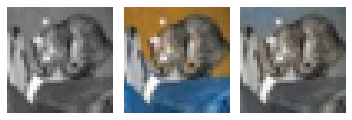

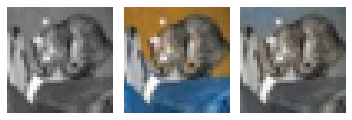

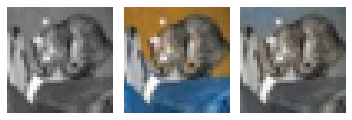

EPOCH: 15.510	trn_loss: 0.005	(3712.19s - 20221.67s remaining)

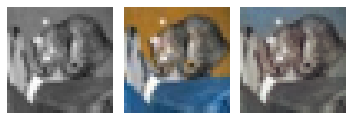

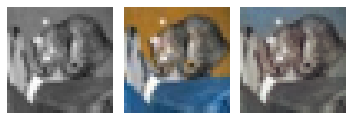

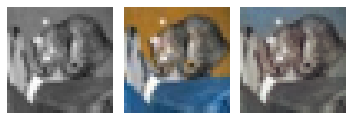

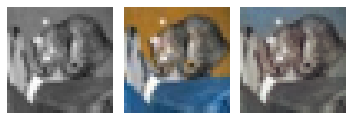

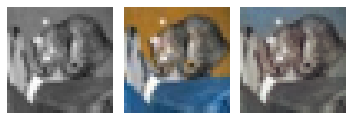

EPOCH: 15.765	trn_loss: 0.004	(3773.46s - 20161.76s remaining)

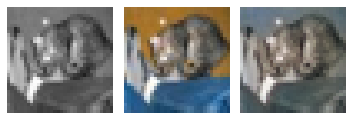

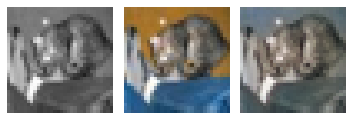

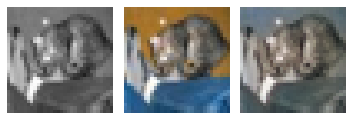

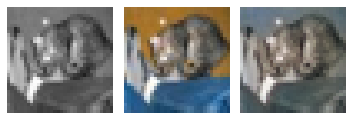

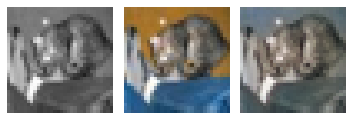

EPOCH: 16.255	trn_loss: 0.004	(3888.49s - 20033.19s remaining)

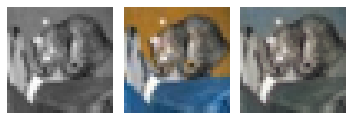

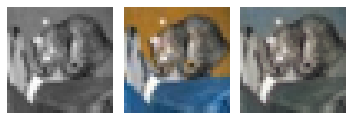

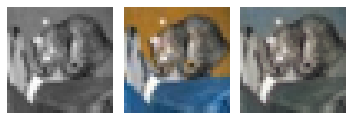

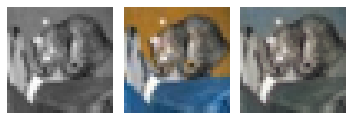

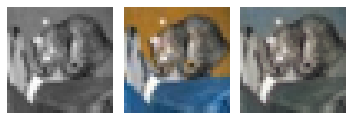

EPOCH: 16.510	trn_loss: 0.005	(3950.04s - 19974.78s remaining)

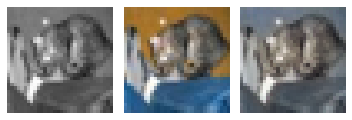

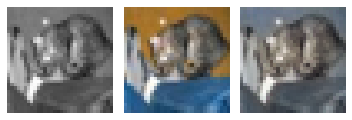

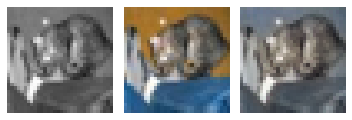

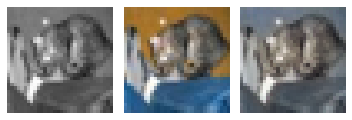

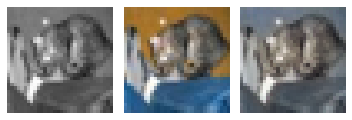

EPOCH: 16.765	trn_loss: 0.004	(4011.75s - 19917.13s remaining)

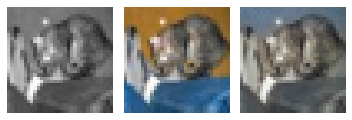

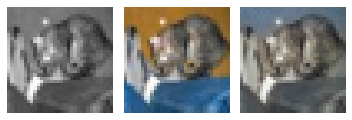

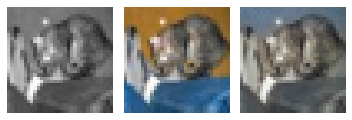

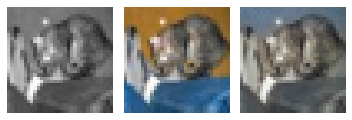

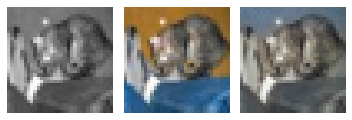

EPOCH: 17.255	trn_loss: 0.004	(4127.39s - 19792.44s remaining)

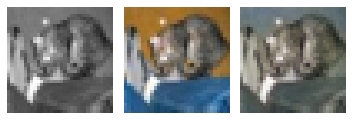

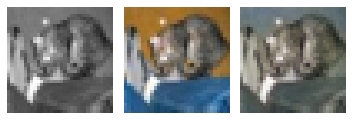

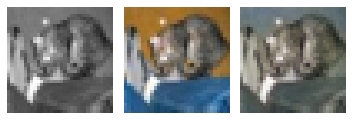

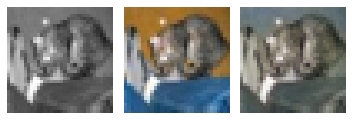

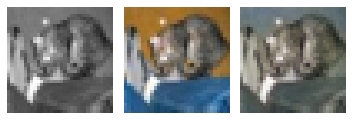

EPOCH: 17.510	trn_loss: 0.004	(4189.06s - 19734.46s remaining)

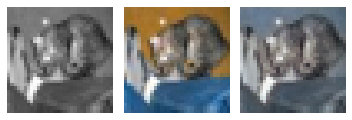

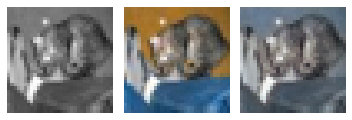

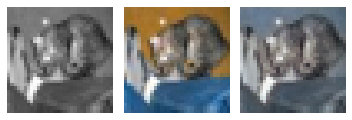

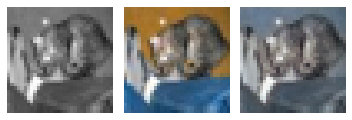

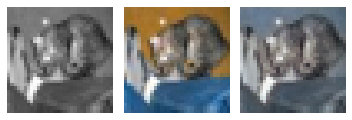

EPOCH: 17.765	trn_loss: 0.004	(4250.77s - 19676.61s remaining)

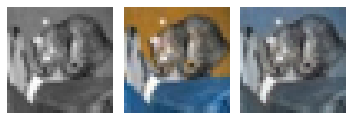

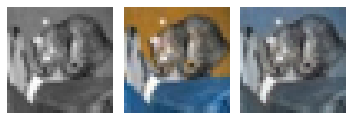

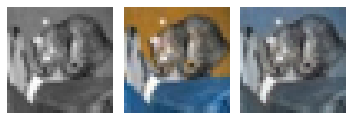

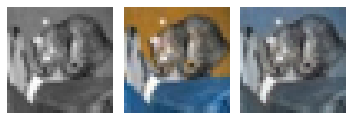

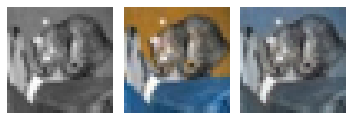

EPOCH: 18.255	trn_loss: 0.004	(4366.08s - 19550.94s remaining)

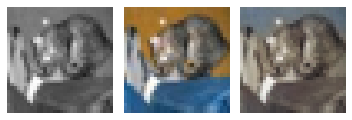

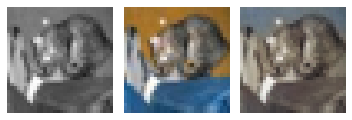

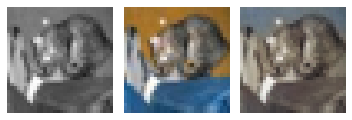

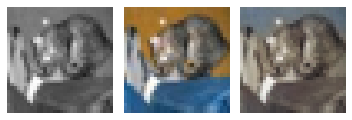

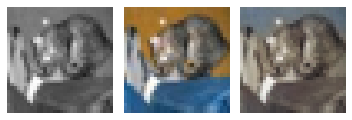

EPOCH: 18.510	trn_loss: 0.004	(4427.53s - 19491.85s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


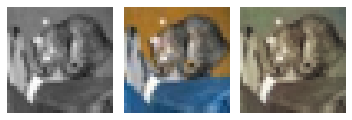

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


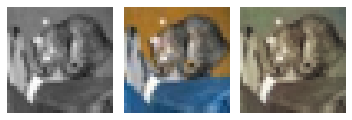

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


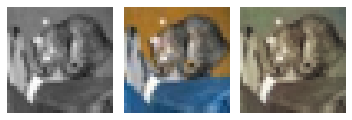

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


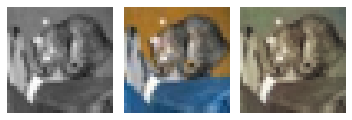

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


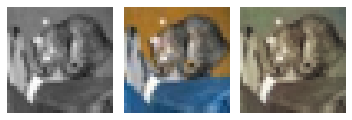

EPOCH: 18.765	trn_loss: 0.004	(4489.31s - 19434.16s remaining)

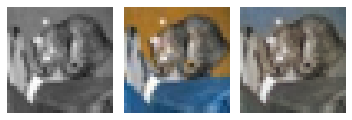

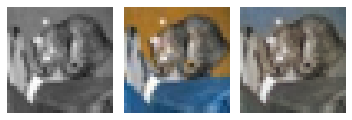

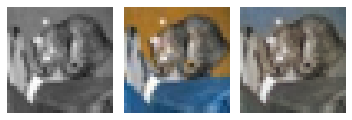

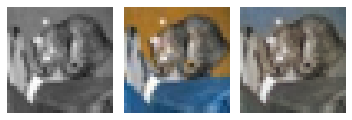

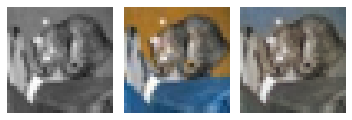

EPOCH: 19.255	trn_loss: 0.004	(4604.59s - 19309.02s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


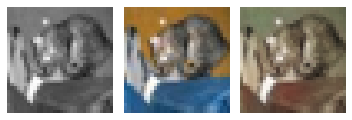

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


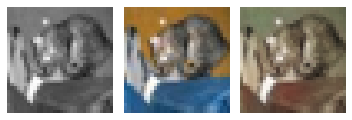

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


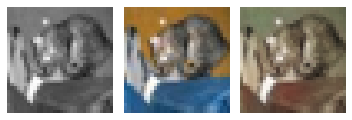

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


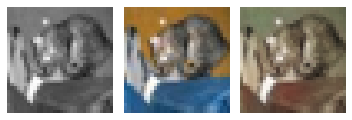

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


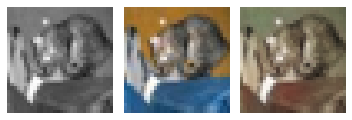

EPOCH: 19.510	trn_loss: 0.004	(4665.96s - 19249.54s remaining)

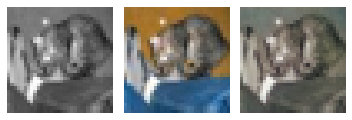

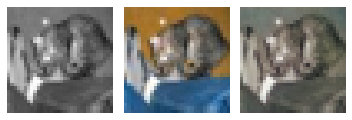

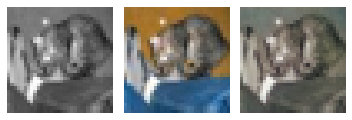

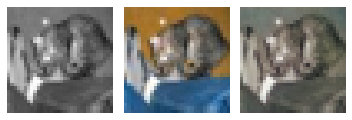

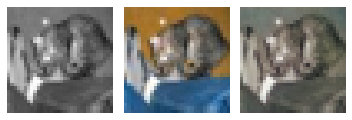

EPOCH: 19.765	trn_loss: 0.004	(4727.11s - 19189.07s remaining)

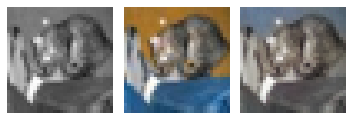

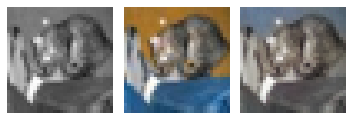

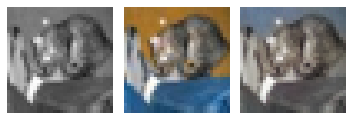

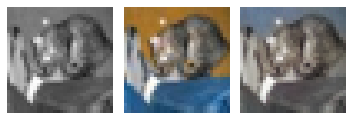

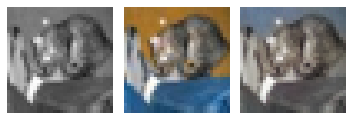

EPOCH: 20.255	trn_loss: 0.003	(4841.42s - 19060.80s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


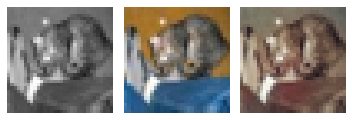

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


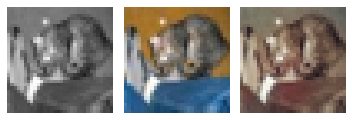

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


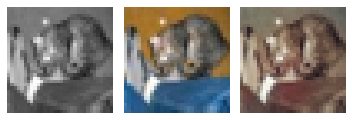

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


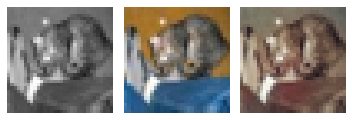

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


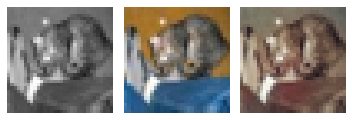

EPOCH: 20.510	trn_loss: 0.004	(4902.92s - 19001.85s remaining)

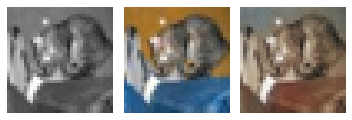

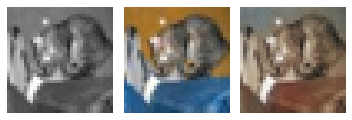

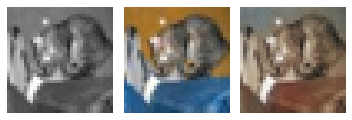

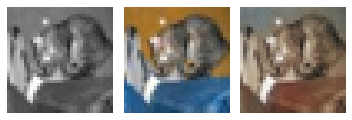

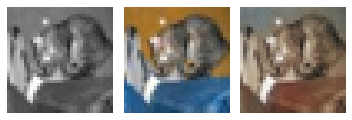

EPOCH: 20.765	trn_loss: 0.004	(4964.67s - 18943.80s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


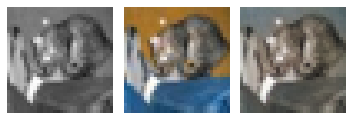

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


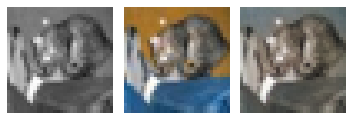

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


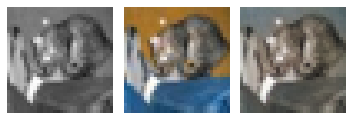

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


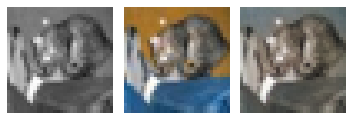

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


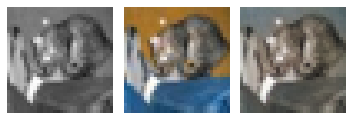

EPOCH: 21.255	trn_loss: 0.003	(5080.53s - 18822.12s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


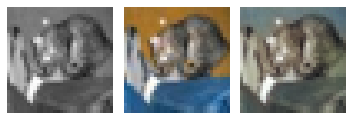

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


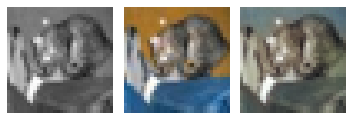

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


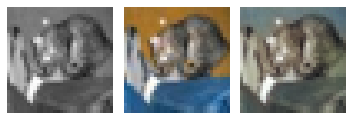

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


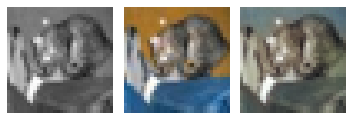

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


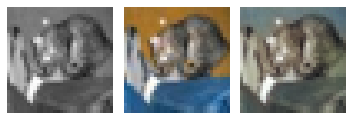

EPOCH: 21.510	trn_loss: 0.003	(5142.34s - 18764.18s remaining)

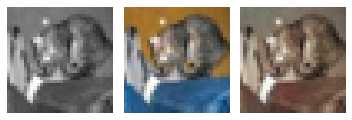

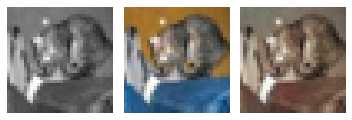

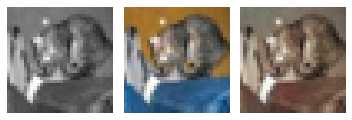

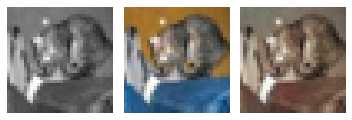

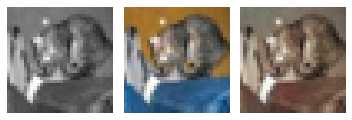

EPOCH: 21.765	trn_loss: 0.003	(5204.07s - 18705.87s remaining)

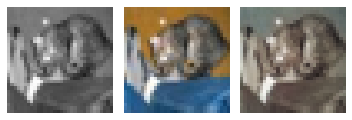

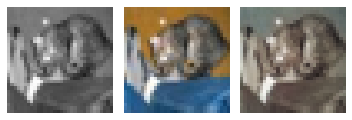

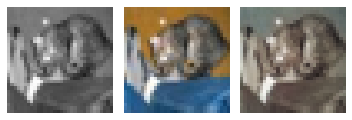

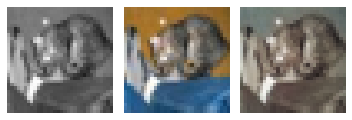

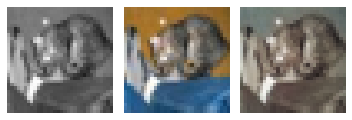

EPOCH: 22.255	trn_loss: 0.003	(5319.49s - 18582.86s remaining)

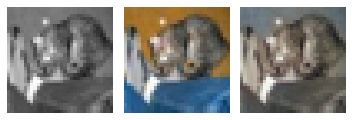

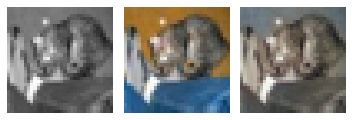

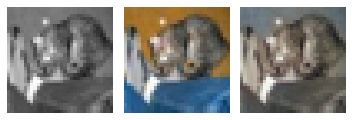

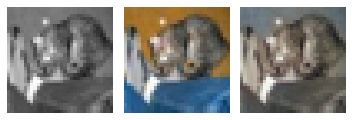

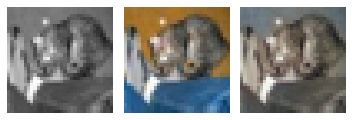

EPOCH: 22.510	trn_loss: 0.004	(5381.37s - 18525.00s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


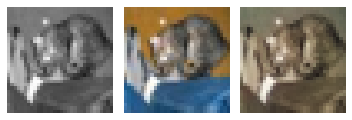

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


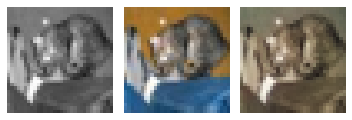

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


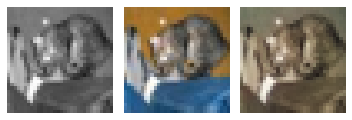

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


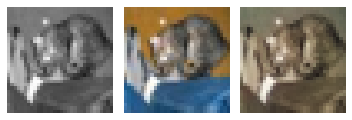

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


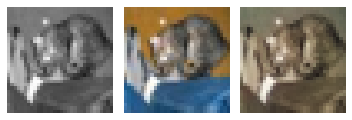

EPOCH: 22.765	trn_loss: 0.003	(5443.34s - 18467.34s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


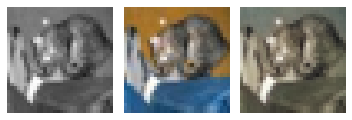

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


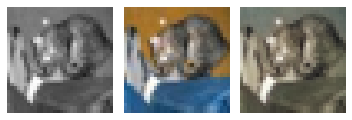

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


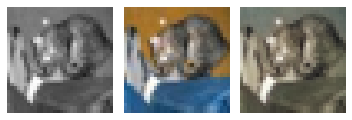

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


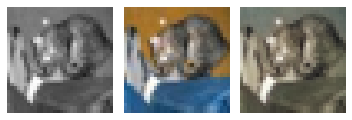

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


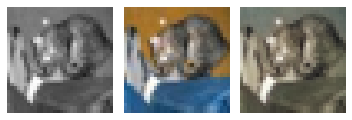

EPOCH: 23.255	trn_loss: 0.003	(5558.95s - 18345.26s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


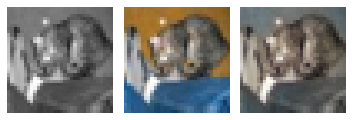

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


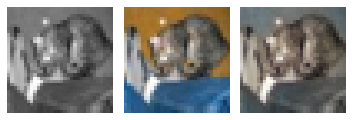

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


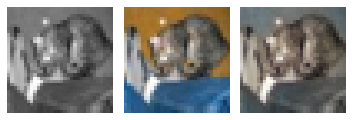

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


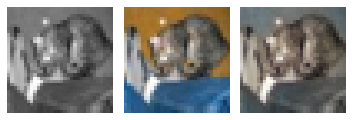

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


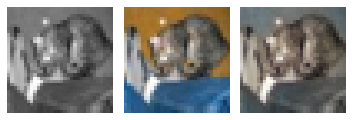

EPOCH: 23.510	trn_loss: 0.003	(5620.84s - 18287.25s remaining)

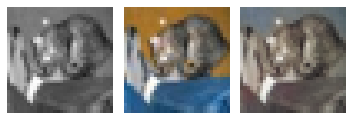

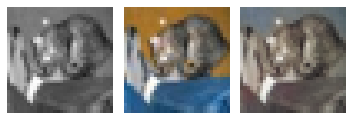

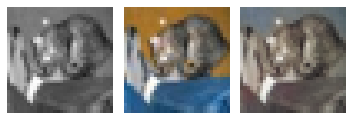

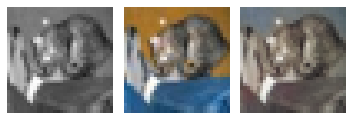

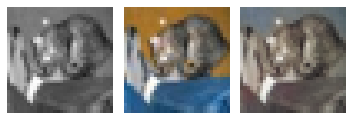

EPOCH: 23.765	trn_loss: 0.003	(5682.72s - 18229.11s remaining)

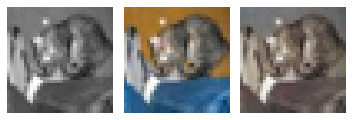

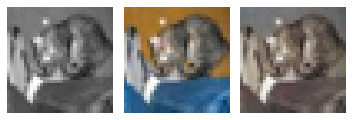

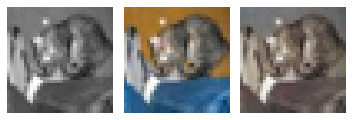

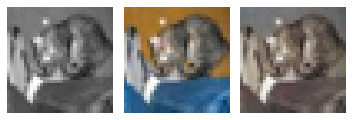

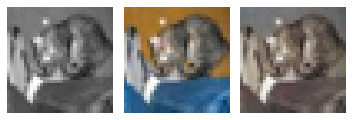

EPOCH: 24.255	trn_loss: 0.003	(5798.30s - 18107.19s remaining)

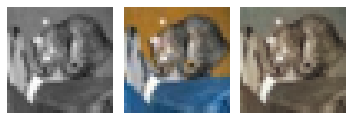

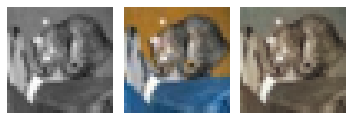

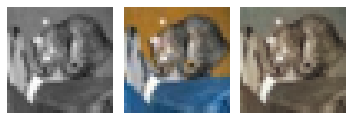

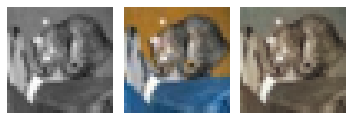

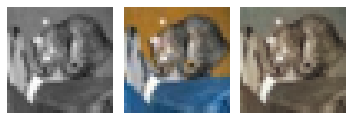

EPOCH: 24.510	trn_loss: 0.003	(5860.01s - 18048.43s remaining)

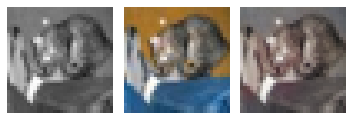

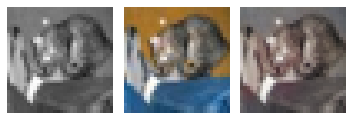

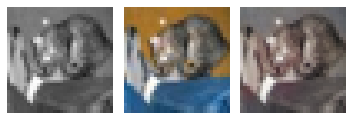

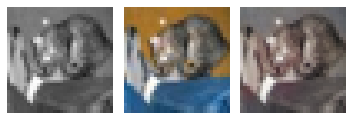

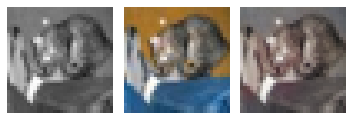

EPOCH: 24.765	trn_loss: 0.003	(5921.85s - 17990.02s remaining)

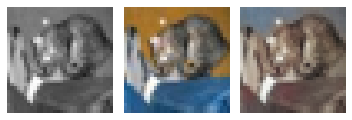

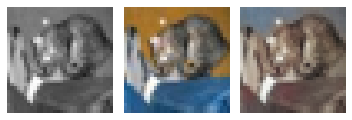

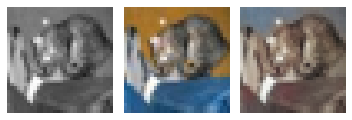

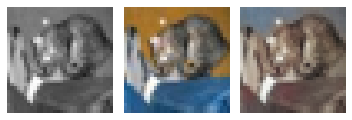

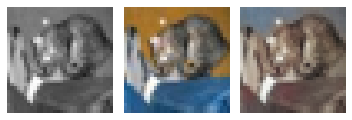

EPOCH: 25.255	trn_loss: 0.003	(6037.65s - 17869.01s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


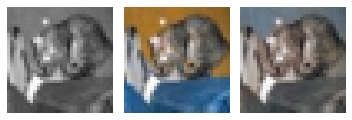

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


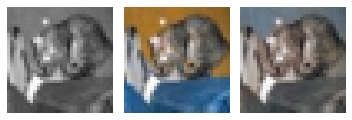

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


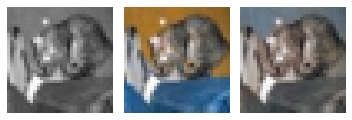

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


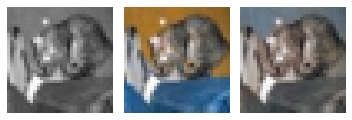

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


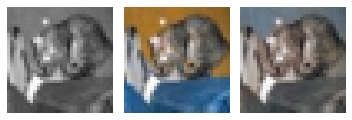

EPOCH: 25.510	trn_loss: 0.002	(6099.48s - 17810.49s remaining)

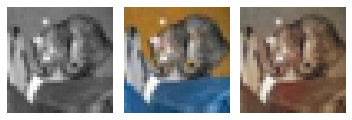

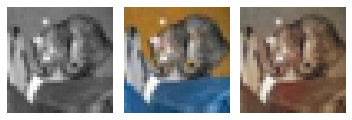

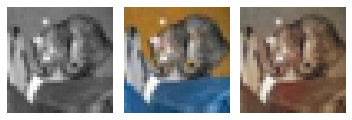

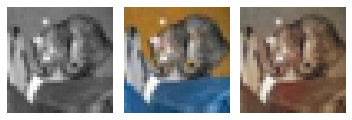

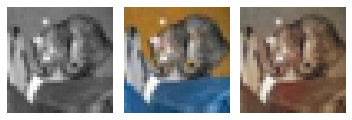

EPOCH: 25.765	trn_loss: 0.003	(6161.33s - 17751.96s remaining)

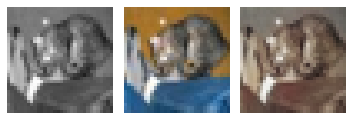

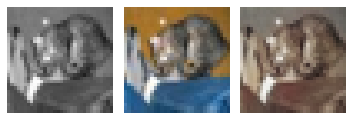

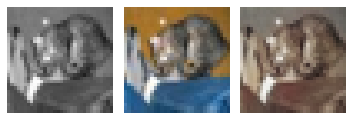

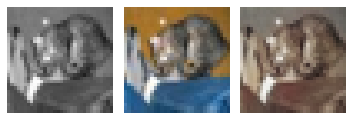

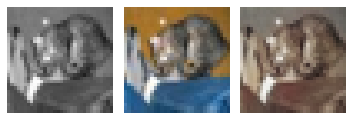

EPOCH: 26.255	trn_loss: 0.003	(6277.06s - 17630.89s remaining)

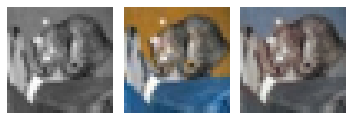

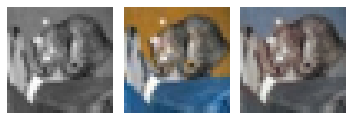

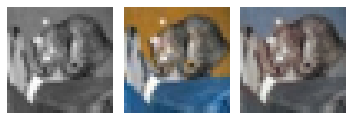

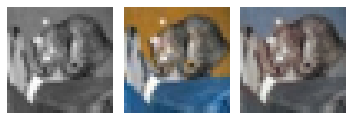

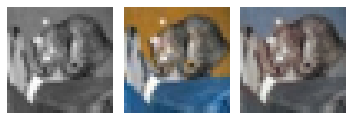

EPOCH: 26.510	trn_loss: 0.003	(6338.76s - 17571.89s remaining)

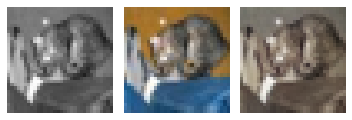

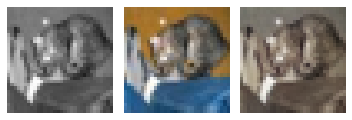

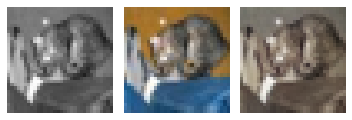

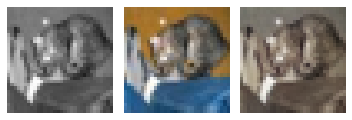

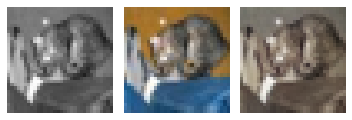

EPOCH: 26.765	trn_loss: 0.003	(6400.49s - 17512.88s remaining)

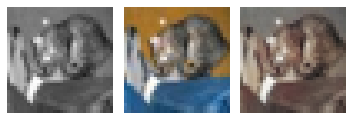

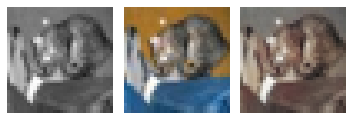

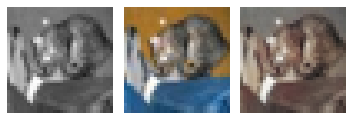

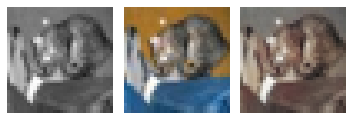

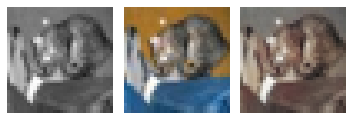

EPOCH: 27.255	trn_loss: 0.003	(6515.98s - 17391.39s remaining)

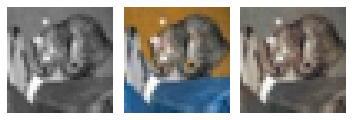

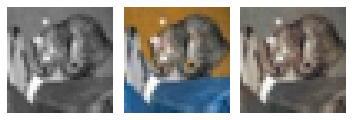

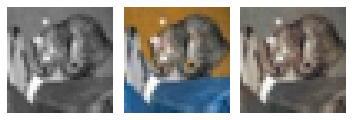

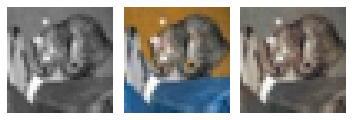

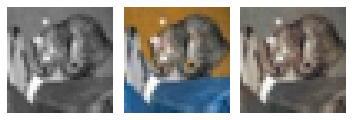

EPOCH: 27.510	trn_loss: 0.003	(6577.60s - 17332.07s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


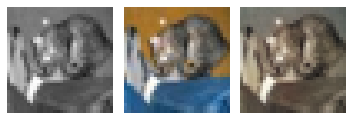

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


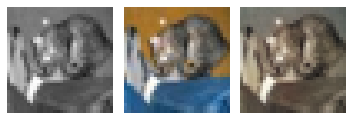

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


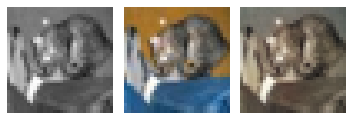

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


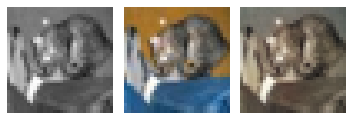

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


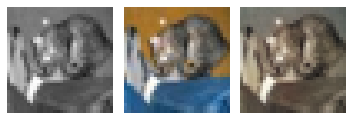

EPOCH: 27.765	trn_loss: 0.002	(6639.69s - 17273.94s remaining)

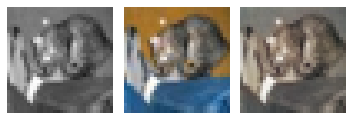

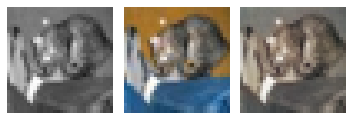

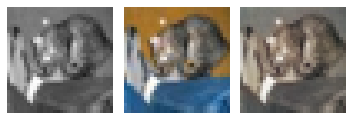

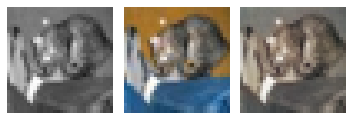

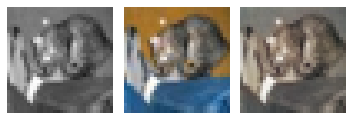

EPOCH: 28.255	trn_loss: 0.002	(6755.27s - 17152.87s remaining)

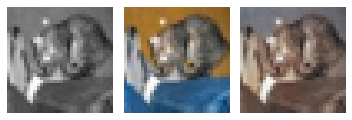

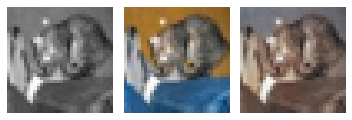

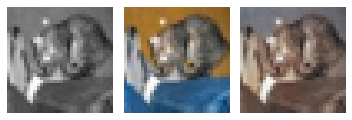

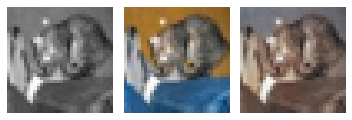

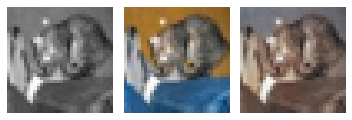

EPOCH: 28.510	trn_loss: 0.002	(6816.94s - 17093.58s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


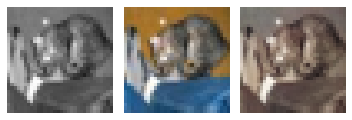

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


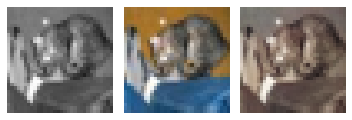

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


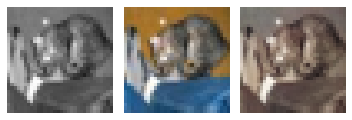

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


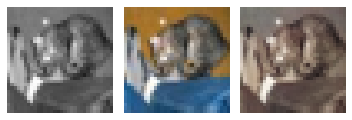

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


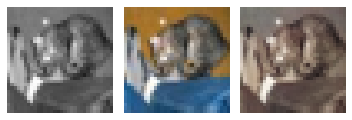

EPOCH: 28.765	trn_loss: 0.003	(6878.89s - 17034.95s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


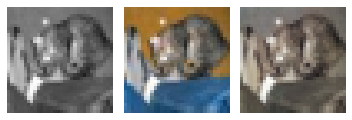

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


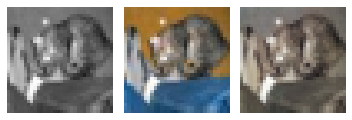

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


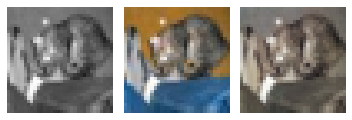

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


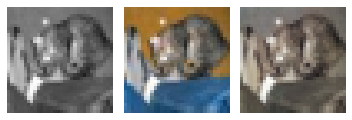

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


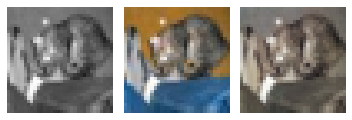

EPOCH: 29.255	trn_loss: 0.002	(6994.59s - 16914.36s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


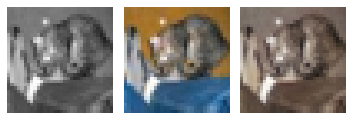

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


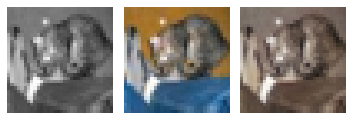

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


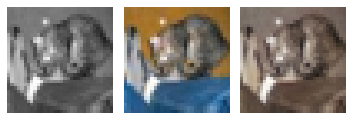

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


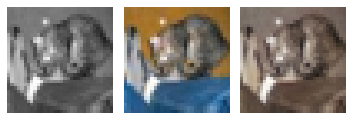

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


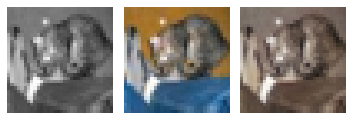

EPOCH: 29.510	trn_loss: 0.003	(7056.61s - 16855.82s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


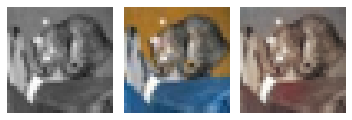

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


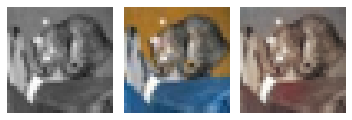

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


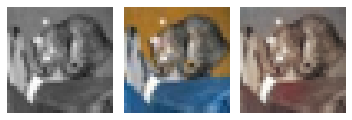

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


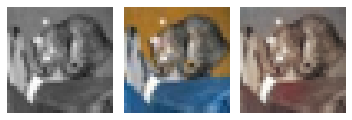

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


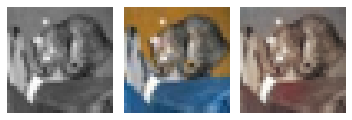

EPOCH: 29.765	trn_loss: 0.002	(7118.64s - 16797.26s remaining)

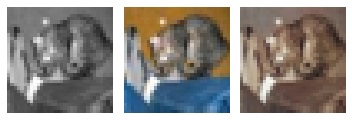

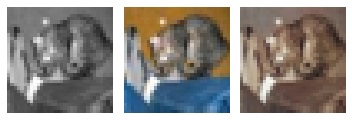

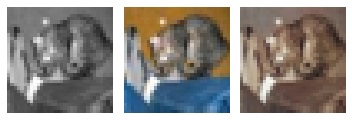

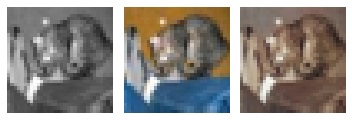

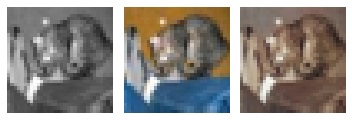

EPOCH: 30.255	trn_loss: 0.002	(7234.20s - 16676.48s remaining)

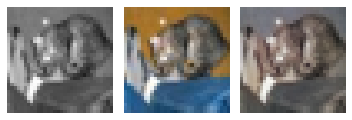

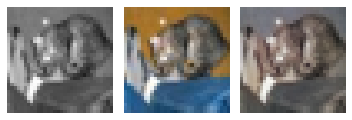

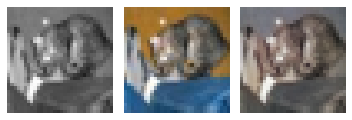

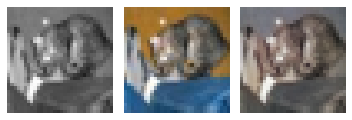

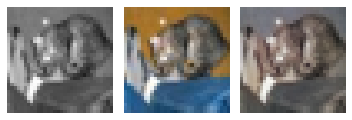

EPOCH: 30.510	trn_loss: 0.002	(7295.96s - 16617.22s remaining)

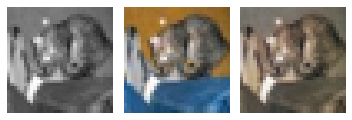

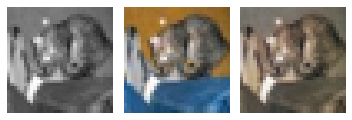

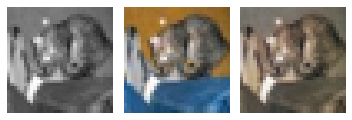

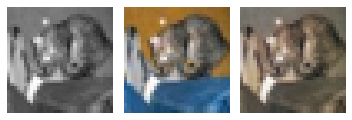

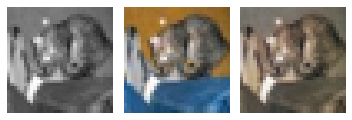

EPOCH: 30.765	trn_loss: 0.002	(7357.70s - 16557.88s remaining)

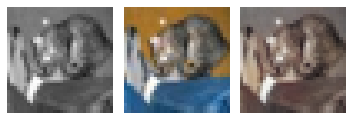

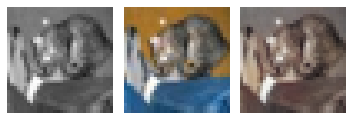

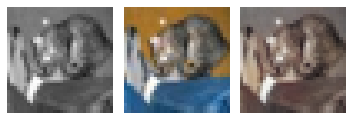

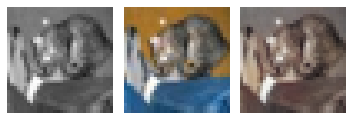

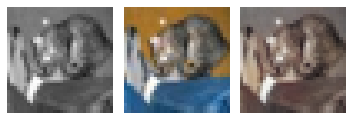

EPOCH: 31.255	trn_loss: 0.002	(7473.09s - 16436.89s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


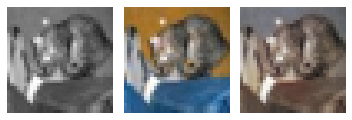

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


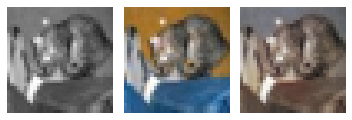

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


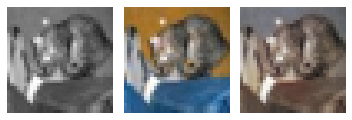

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


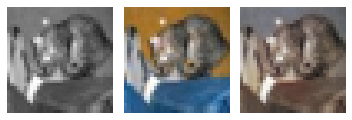

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


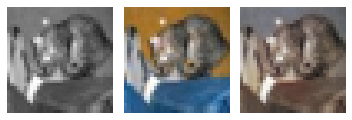

EPOCH: 31.510	trn_loss: 0.002	(7534.90s - 16377.67s remaining)

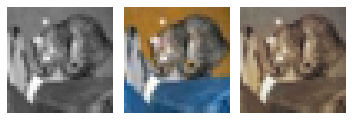

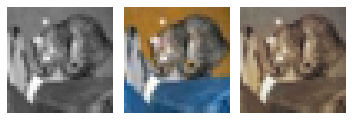

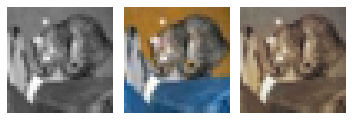

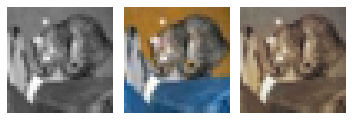

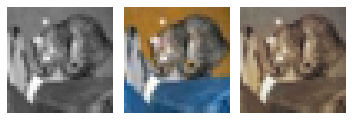

EPOCH: 31.765	trn_loss: 0.002	(7596.81s - 16318.62s remaining)

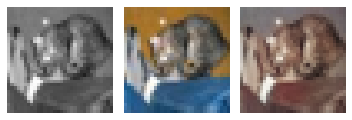

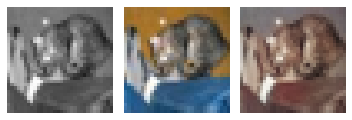

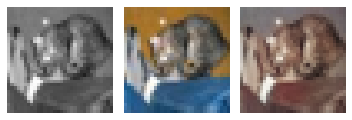

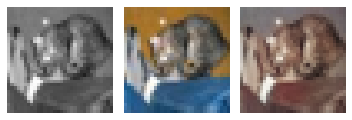

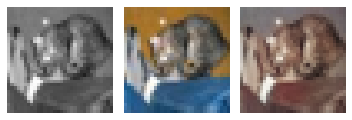

EPOCH: 32.255	trn_loss: 0.002	(7712.45s - 16198.34s remaining)

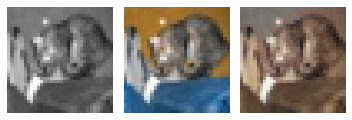

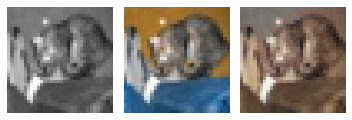

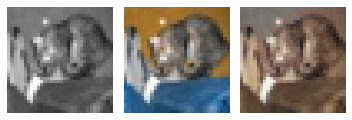

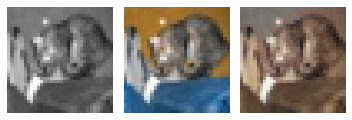

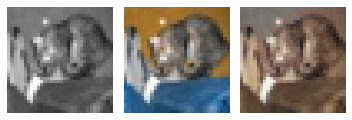

EPOCH: 32.510	trn_loss: 0.002	(7774.16s - 16138.83s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


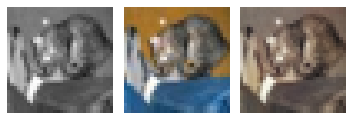

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


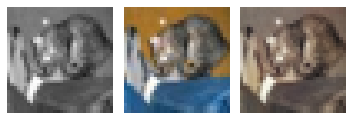

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


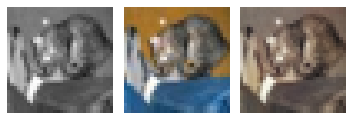

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


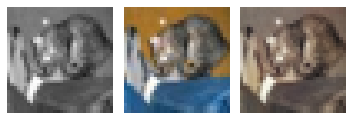

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


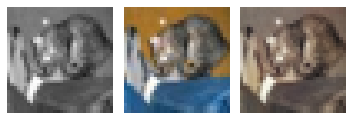

EPOCH: 32.765	trn_loss: 0.002	(7836.20s - 16079.95s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


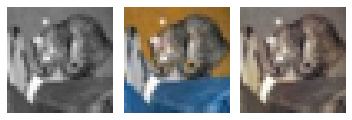

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


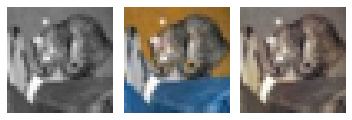

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


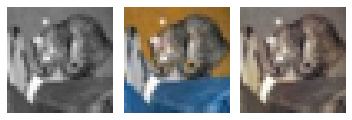

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


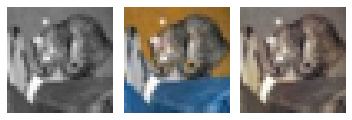

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


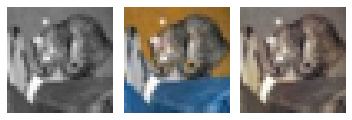

EPOCH: 33.255	trn_loss: 0.002	(7952.14s - 15960.39s remaining)

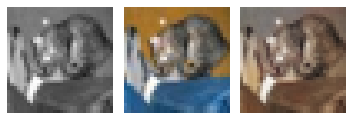

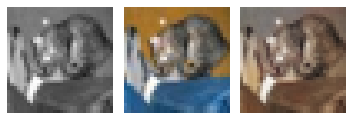

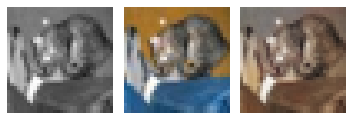

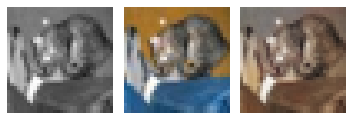

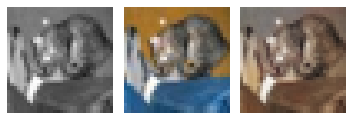

EPOCH: 33.510	trn_loss: 0.002	(8014.20s - 15901.49s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


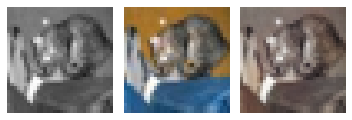

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


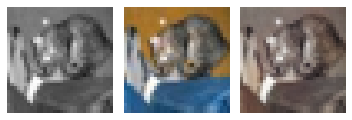

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


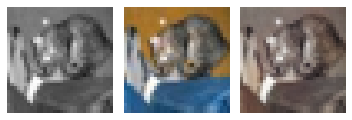

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


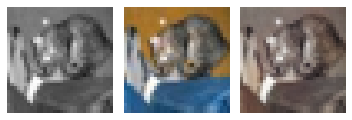

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


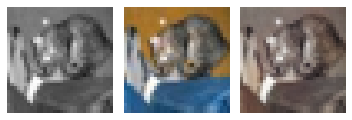

EPOCH: 33.765	trn_loss: 0.002	(8076.29s - 15842.61s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


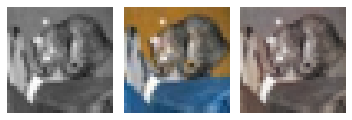

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


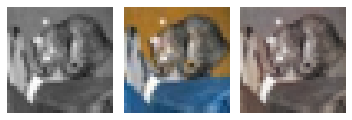

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


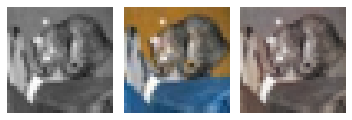

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


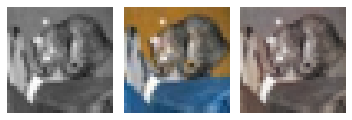

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


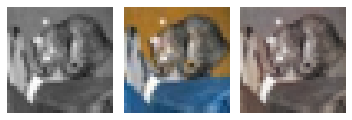

EPOCH: 34.255	trn_loss: 0.002	(8191.93s - 15722.55s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


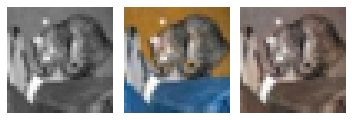

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


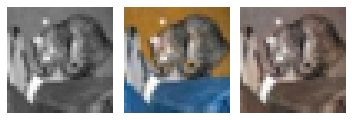

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


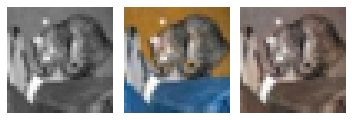

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


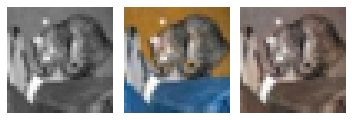

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


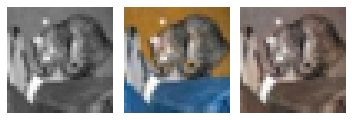

EPOCH: 34.510	trn_loss: 0.002	(8253.96s - 15663.48s remaining)

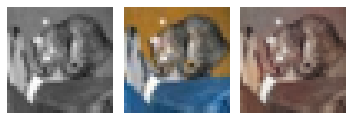

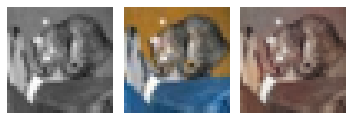

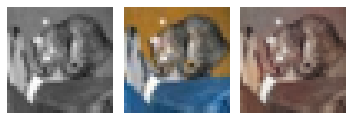

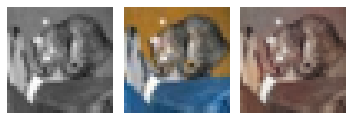

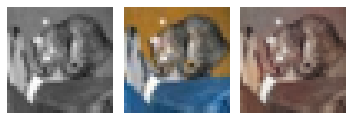

EPOCH: 34.765	trn_loss: 0.002	(8315.78s - 15603.99s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


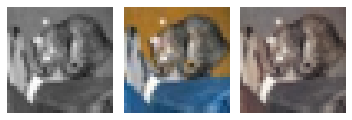

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


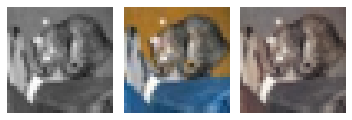

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


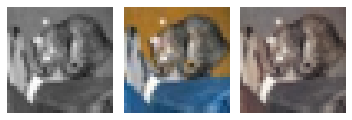

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


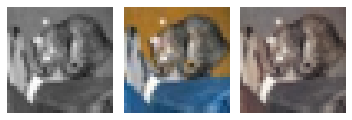

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


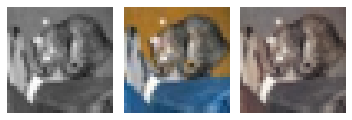

EPOCH: 35.255	trn_loss: 0.002	(8431.44s - 15484.07s remaining)

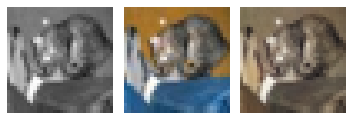

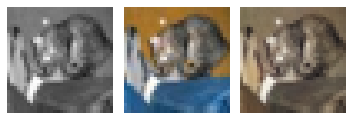

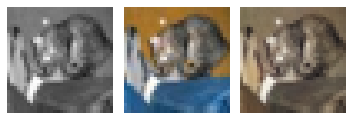

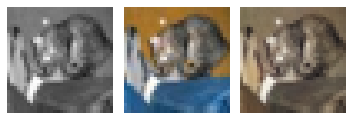

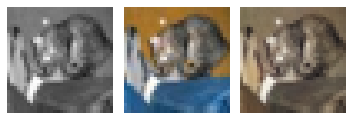

EPOCH: 35.510	trn_loss: 0.002	(8493.09s - 15424.23s remaining)

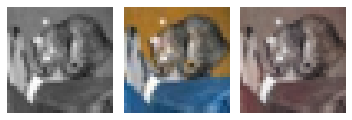

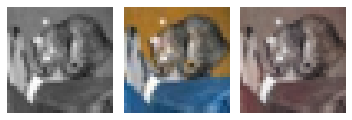

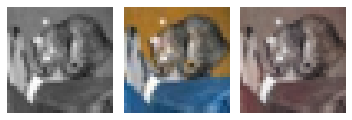

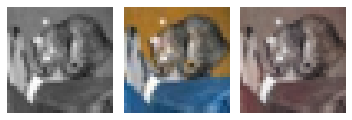

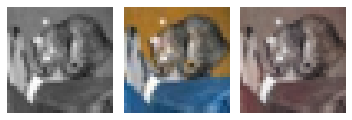

EPOCH: 35.536	trn_loss: 0.002	(8501.43s - 15422.19s remaining)

In [ ]:
# train the model over the increasing epochs

model,optimizer,criterion = get_model()
exp_lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, \
                                              step_size = 10, gamma=0.1)
_val_dl = DataLoader(val_ds , batch_size=1, shuffle = True)

n_epochs = 100
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx,data in enumerate(trn_dl):
        loss = train_batch(model ,data ,optimizer, criterion)
        log.record(ex + (bx +1)/N , trn_loss=loss, end = '\r')

        if (bx+1)%50 ==0:
            for _ in range(5):
                a,b = next(iter(val_dl))
                _b = model(a)
                subplots([a[0],b[0],_b[0]],nc=3, \
                         figsize=(5,5))
